In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

2024-03-29 07:47:47.185356: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 07:47:47.185398: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 07:47:47.185435: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 07:47:47.193228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
nRowsRead = None 

df1=pd.read_csv(r"../dataset/Tuesday-WorkingHours.pcap_ISCX.csv")
df2=pd.read_csv(r"../dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df3=pd.read_csv(r"../dataset/Monday-WorkingHours.pcap_ISCX.csv")
df4=pd.read_csv(r"../dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df5=pd.read_csv(r"../dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df6=pd.read_csv(r"../dataset/Wednesday-workingHours.pcap_ISCX.csv")
df7=pd.read_csv(r"../dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df8=pd.read_csv(r"../dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv")

In [3]:
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df = pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6
df = pd.concat([df,df7])
del df7
df = pd.concat([df,df8])
del df8

nRow, nCol = df.shape

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 191032
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max               

In [5]:
df.isnull().sum()

 Destination Port                  0
 Flow Duration                     0
 Total Fwd Packets                 0
 Total Backward Packets            0
Total Length of Fwd Packets        0
 Total Length of Bwd Packets       0
 Fwd Packet Length Max             0
 Fwd Packet Length Min             0
 Fwd Packet Length Mean            0
 Fwd Packet Length Std             0
Bwd Packet Length Max              0
 Bwd Packet Length Min             0
 Bwd Packet Length Mean            0
 Bwd Packet Length Std             0
Flow Bytes/s                    1358
 Flow Packets/s                    0
 Flow IAT Mean                     0
 Flow IAT Std                      0
 Flow IAT Max                      0
 Flow IAT Min                      0
Fwd IAT Total                      0
 Fwd IAT Mean                      0
 Fwd IAT Std                       0
 Fwd IAT Max                       0
 Fwd IAT Min                       0
Bwd IAT Total                      0
 Bwd IAT Mean                      0
 

In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)  

In [7]:
print(df.duplicated().sum(), "fully duplicate rows to remove")

307078 fully duplicate rows to remove


In [8]:
df.drop_duplicates(inplace=True)

In [9]:
print(df.duplicated().sum(), "fully duplicate rows to remove")

0 fully duplicate rows to remove


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2520798 entries, 0 to 191032
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max               

In [11]:
df_encoded = df.copy()

le = LabelEncoder()

df_encoded[' Label'] = le.fit_transform(df[' Label'])

X = df_encoded.drop(' Label', axis=1)
y = df_encoded[' Label']

In [12]:
X = df.drop(' Label', axis=1)
y = df[' Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
print(y_train.value_counts())

 Label
BENIGN                        1676045
DoS Hulk                       138277
DDoS                           102411
PortScan                        72555
DoS GoldenEye                    8229
FTP-Patator                      4745
DoS slowloris                    4308
DoS Slowhttptest                 4182
SSH-Patator                      2575
Bot                              1558
Web Attack � Brute Force         1176
Web Attack � XSS                  522
Infiltration                       29
Web Attack � Sql Injection         17
Heartbleed                          9
Name: count, dtype: int64


In [14]:
sampling_strategy_over = {
    "DoS Hulk": 200000, 
    "DDoS": 150000, 
    "PortScan": 100000, 
    "DoS GoldenEye": 10000, 
    "FTP-Patator": 7000, 
    "DoS slowloris": 7000, 
    "DoS Slowhttptest": 7000, 
    "SSH-Patator": 5000, 
    "Bot": 3000, 
    "Web Attack � Brute Force": 2000, 
    "Web Attack � XSS": 1500, 
    "Infiltration": 1500, 
    "Web Attack � Sql Injection": 1500, 
    "Heartbleed": 1500
}

# undersampling the majority class
sampling_strategy_under = {
    "BENIGN": 500000  
}

In [15]:
over = SMOTE(sampling_strategy=sampling_strategy_over)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)



X_train_res, y_train_res = over.fit_resample(X_train, y_train)
X_train_res, y_train_res= under.fit_resample(X_train_res, y_train_res)

print(y_train_res.value_counts())


 Label
BENIGN                        500000
DoS Hulk                      200000
DDoS                          150000
PortScan                      100000
DoS GoldenEye                  10000
DoS Slowhttptest                7000
DoS slowloris                   7000
FTP-Patator                     7000
SSH-Patator                     5000
Bot                             3000
Web Attack � Brute Force        2000
Heartbleed                      1500
Infiltration                    1500
Web Attack � Sql Injection      1500
Web Attack � XSS                1500
Name: count, dtype: int64


In [16]:
#CNN without fine tuning

In [16]:
# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for Conv1D
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# One-hot encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

In [28]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'  # Specify the GPU device number

In [17]:


model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train_one_hot.shape[1], activation='softmax'))  

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model with one-hot encoded labels
model.fit(X_train_scaled, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test_one_hot))

2024-03-29 07:48:55.997520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 72772 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:01:00.0, compute capability: 8.0
2024-03-29 07:48:55.999024: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79065 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:81:00.0, compute capability: 8.0


Epoch 1/10


2024-03-29 07:48:59.018294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-03-29 07:48:59.763349: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcde404b1f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-29 07:48:59.763381: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-29 07:48:59.763387: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-29 07:48:59.768104: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-29 07:48:59.850883: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63020/63020 [==============================] - 253s 4ms/step - loss: 0.1168 - accuracy: 0.9579 - val_loss: 0.0590 - val_accuracy: 0.9764
Epoch 2/10
63020/63020 [==============================] - 248s 4ms/step - loss: 0.0752 - accuracy: 0.9701 - val_loss: 0.0505 - val_accuracy: 0.9782
Epoch 3/10
63020/63020 [==============================] - 256s 4ms/step - loss: 0.0660 - accuracy: 0.9733 - val_loss: 0.0473 - val_accuracy: 0.9804
Epoch 4/10
63020/63020 [==============================] - 249s 4ms/step - loss: 0.0620 - accuracy: 0.9747 - val_loss: 0.0454 - val_accuracy: 0.9801
Epoch 5/10
63020/63020 [==============================] - 249s 4ms/step - loss: 0.0594 - accuracy: 0.9756 - val_loss: 0.0452 - val_accuracy: 0.9795
Epoch 6/10
63020/63020 [==============================] - 248s 4ms/step - loss: 0.0573 - accuracy: 0.9767 - val_loss: 0.0415 - val_accuracy: 0.9830
Epoch 7/10
63020/63020 [==============================] - 249s 4ms/step - loss: 0.0555 - accuracy: 0.9773 - val_loss: 0.038

In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_one_hot)

print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Loss: {:.2f}%".format(test_loss * 100))

15755/15755 [==============================] - 16s 1ms/step - loss: 0.0332 - accuracy: 0.9904
Test Accuracy: 99.04%
Test Loss: 3.32%


In [19]:
# Predict the classes with the model
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

15755/15755 [==============================] - 12s 778us/step


In [20]:
# Convert one-hot encoded y_test to class labels
y_true = np.argmax(y_test_one_hot, axis=1)

In [21]:
# Classification report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))


/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.99      1.00      0.99    419012
                       Bot       0.00      0.00      0.00       390
                      DDoS       1.00      1.00      1.00     25603
             DoS GoldenEye       0.99      0.96      0.97      2057
                  DoS Hulk       1.00      0.94      0.97     34569
          DoS Slowhttptest       0.98      0.90      0.94      1046
             DoS slowloris       0.96      0.95      0.95      1077
               FTP-Patator       1.00      0.99      0.99      1186
                Heartbleed       0.00      0.00      0.00         2
              Infiltration       0.00      0.00      0.00         7
                  PortScan       0.94      0.98      0.96     18139
               SSH-Patator       0.99      0.90      0.94       644
  Web Attack � Brute Force       0.00      0.00      0.00       294
Web Attack � Sql Injection       0.00      0.00

/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support


precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

# Compute micro average precision, recall, f1-score
precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='macro')
print(f"Micro Average Precision: {precision_micro:.4f}")
print(f"Micro Average Recall: {recall_micro:.4f}")
print(f"Micro Average F1-Score: {f1_score_micro:.4f}")

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')


/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Micro Average Precision: 0.5900
Micro Average Recall: 0.5739
Micro Average F1-Score: 0.5816
Precision: 0.9888866069333596
Recall: 0.9904216915264995
F1 Score: 0.9895774372366672
Accuracy: 0.9904216915264995


/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


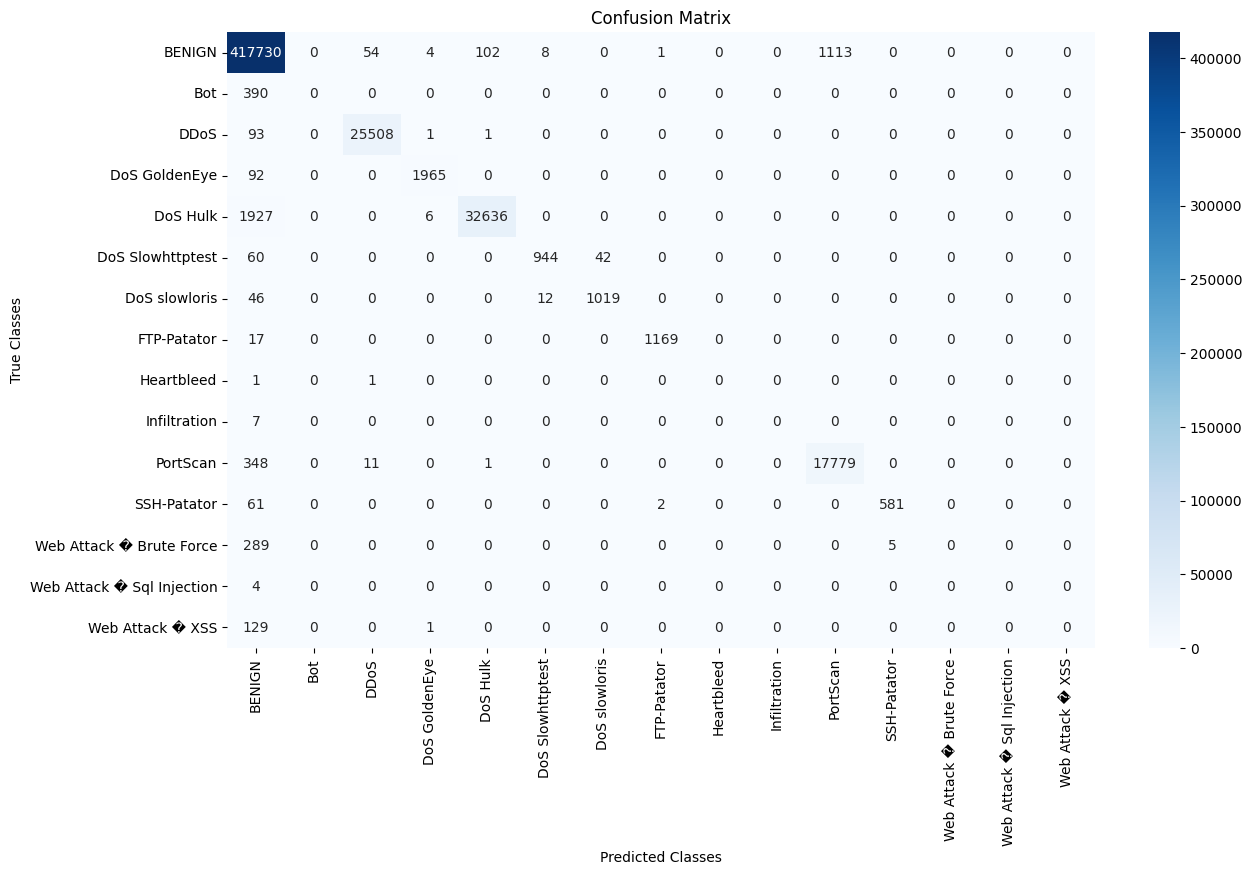

In [24]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()

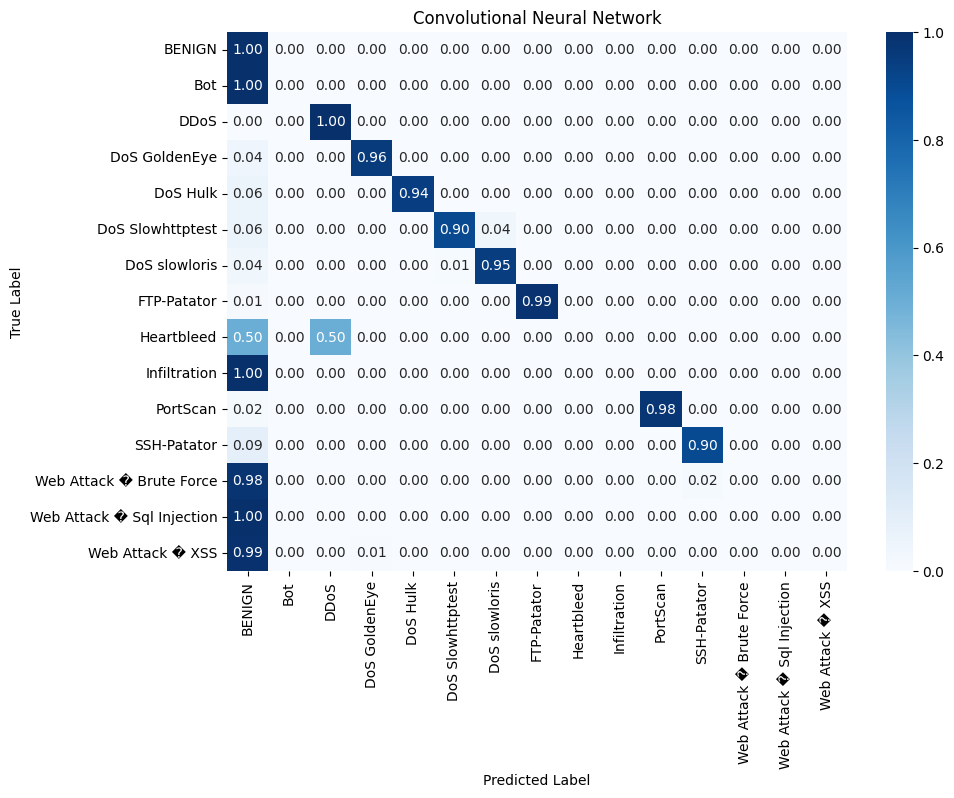

In [27]:
# Normalize the confusion matrix by rows
row_sums = conf_matrix.sum(axis=1)
conf_matrix_normalized = conf_matrix / row_sums[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',xticklabels=le.classes_, yticklabels=le.classes_)  # Use fmt=".2f" to format the numbers
plt.title("Convolutional Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [39]:
model.save('../NIDS/saved/cnn_without_finetune_model.h5')

/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 76, 64)            256       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 38, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2432)              0         
                                                                 
 dense_2 (Dense)             (None, 50)                121650    
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 15)                765       
                                                      

In [41]:
model.save('CNN_without_finetuning.h5')
print("Model Saved")


Model Saved


/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
